In [62]:
%pip install seaborn



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import scipy.stats as st

sns.set_theme(style='whitegrid')

In [64]:
alpha = 0.05
confidence = 1 - alpha

In [65]:
# Load the data
df = pd.read_csv("movie_metadata.csv")
df = df.drop_duplicates()
df = df.dropna(thresh=int(df.shape[1]*0.7))  # Keep rows with at least 70% non-null

In [66]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]

Research Question 1: Does IMDb Score Impact Gross Income?

In [67]:
# Get IMBD and gross income DF
q1_df = df[['imdb_score', 'gross']].dropna()
q1_df = q1_df[q1_df['gross'] > 0]
q1_df = remove_outliers_iqr(q1_df, 'gross')

In [68]:
%pip install statsmodels


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Q1 Exploratory Data Analysis (EDA)

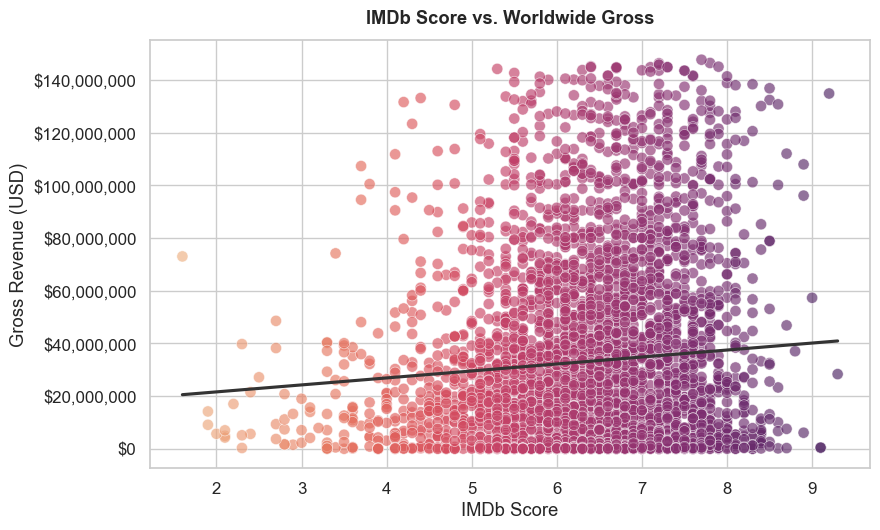

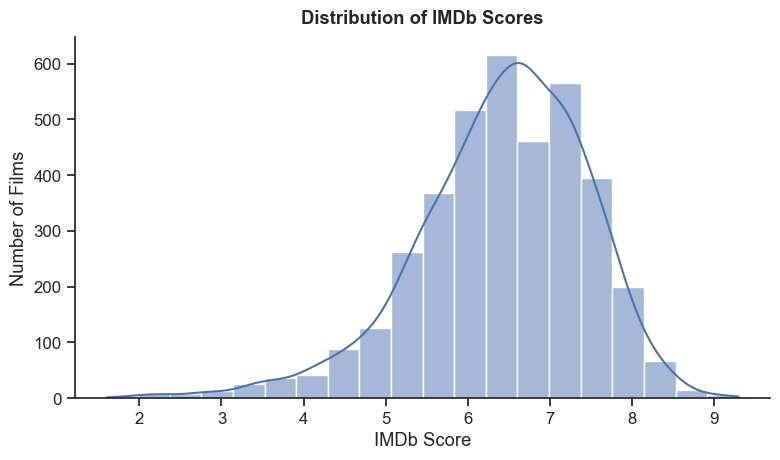

,count,mean,std,min,25%,50%,75%,max
score_bin,,,,,,,,
≤5,317.000000,"$24,985,166",27576367.184135,$721,"$5,660,084","$15,549,702","$33,860,010","$133,103,929"
5‑6,791.000000,"$33,074,353",31973748.008314,$162,"$8,952,366","$23,292,105","$48,021,338","$144,156,464"
6‑7,1465.000000,"$33,700,814",35385162.507073,$828,"$3,273,588","$23,014,504","$52,799,004","$145,096,820"
7‑8,1080.000000,"$34,407,158",37991619.843142,$728,"$3,150,468","$19,026,890","$54,137,143","$147,637,474"
8‑9,162.000000,"$39,049,369",41816823.255810,"$8,060","$5,425,485","$23,372,603","$65,807,184","$141,319,195"
9‑10,5.000000,"$44,271,521",55821253.468362,"$447,093","$447,093","$28,341,469","$57,300,000","$134,821,952"


In [69]:
def q1_visualize(df):

    import matplotlib.pyplot as plt
    import matplotlib.ticker as mtick
    import seaborn as sns
    import pandas as pd

    # Clean data
    df = df[['imdb_score', 'gross']].dropna()

    # Scatter plot
    with sns.axes_style("whitegrid"), sns.plotting_context("notebook", font_scale=1.1):
        fig, ax = plt.subplots(figsize=(9, 5.5))

        sns.scatterplot(
            data=df, x='imdb_score', y='gross',
            s=65, alpha=0.65, edgecolor='w', linewidth=0.5,
            palette="flare", hue='imdb_score', ax=ax, legend=False
        )

        sns.regplot(
            data=df, x='imdb_score', y='gross',
            scatter=False, color="#333333", ax=ax, ci=None
        )

        ax.set_title("IMDb Score vs. Worldwide Gross", pad=12, weight='semibold')
        ax.set_xlabel("IMDb Score")
        ax.set_ylabel("Gross Revenue (USD)")
        ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
        plt.tight_layout()
        plt.show()

    # Histogram
    with sns.axes_style("ticks"), sns.plotting_context("notebook", font_scale=1.1):
        fig, ax = plt.subplots(figsize=(8, 4.8))

        sns.histplot(
            df['imdb_score'], bins=20, kde=True,
            color="#4C72B0", edgecolor='white', ax=ax
        )

        ax.set_title("Distribution of IMDb Scores", pad=10, weight='semibold')
        ax.set_xlabel("IMDb Score")
        ax.set_ylabel("Number of Films")
        sns.despine(ax=ax)
        plt.tight_layout()
        plt.show()

    # q1 data summary
    bins = [0, 5, 6, 7, 8, 9, 10]
    labels = ["≤5", "5‑6", "6‑7", "7‑8", "8‑9", "9‑10"]
    df['score_bin'] = pd.cut(df['imdb_score'], bins=bins, labels=labels, right=False)
    grouped = df.groupby('score_bin', observed=True)['gross'].describe()

    display(
        grouped.style
            .format('${:,.0f}', subset=['mean', 'min', '25%', '50%', '75%', 'max'])
            .set_caption("Summary of Gross Revenue by IMDb Score Bins")
            .set_properties(**{'background-color': 'white', 'color': 'black'})
            .set_table_styles([
                {'selector': 'thead th', 'props': [('font-weight', 'bold')]},
                {'selector': 'th.row_heading', 'props': [('font-weight', 'bold')]},
                {'selector': 'caption', 'props': [('caption-side', 'top'), ('color', 'black'), ('font-size', '16px'), ('font-weight', 'bold')]}
            ])
    )

q1_visualize(q1_df)

Q1 Statistical Inference

In [70]:
def q1_inference():
    imdb_score = q1_df['imdb_score']
    gross = q1_df['gross']

    # Correlation and R2
    pearsons = st.pearsonr(imdb_score, gross, alternative='two-sided')
    r = pearsons.statistic
    r2 = r**2
    pearsons_pvalue = pearsons.pvalue
    pearsons_is_significant = pearsons_pvalue < alpha

    print(f"Correlation (r): {r}, r2: {r2}, pvalue: {pearsons_pvalue}, significant?: {pearsons_is_significant}")

    # Confidence intervals
    confidence_interval = pearsons.confidence_interval(confidence)
    print(f"Confidence Interval [{confidence_interval.low}, {confidence_interval.high}]")

    # ANOVA
    grouped_budgets = [group["gross"].values for _, group in q1_df.groupby("imdb_score")]
    anova = st.f_oneway(*grouped_budgets)
    F = anova.statistic
    anova_pvalue = anova.pvalue
    anova_is_significant = anova_pvalue < alpha
    print(f"ANOVA: F={F}, p={anova_pvalue}, significant?: {anova_is_significant}")

q1_inference()

Correlation (r): 0.07838095278890861, r2: 0.00614357376009712, pvalue: 1.2327335093677622e-06, significant?: True
Confidence Interval [0.046783950573995266, 0.10982126201185041]
ANOVA: F=1.4262654762338822, p=0.010213510010507736, significant?: True


**Q1 Formal Statistical Testing**

We will use the two-sided *Pearson Correlation Test* approach.

Null Hypothesis ($H_0$): $\rho = 0$ (there is no linear correlation between the IMDb Score and Gross Income)

Alternative Hypothesis ($H_1$): $\rho \neq 0$ (there is a linear correlation between the IMDb Score and Gross Income)

Significance Level: $\alpha = 0.05$. We will reject $H_0$ if the p-value $< 0.05$.

In [71]:
from scipy.stats import pearsonr

def q1_statistical_testing():
    imdb_score = q1_df['imdb_score']
    gross = q1_df['gross']
    alpha = 0.05

    r, p_value = pearsonr(imdb_score, gross, alternative='two-sided')
    print(f"Pearson Correlation Coefficient (r) = {r}, p-value = {p_value}")
    if p_value < alpha:
        print("We rejected H0 because we found a correlation between IMDb Score and Gross Income")
    else:
        print("We failed to reject H0 because there is no correlation between IMDb Score and Gross Income")
    
q1_statistical_testing()

Pearson Correlation Coefficient (r) = 0.07838095278890861, p-value = 1.2327335093677622e-06
We rejected H0 because we found a correlation between IMDb Score and Gross Income


**Conclusion:** The scatter plot shows a faint upward trend, which suggests that a higher IMDb score might be associated with a higher gross income. This is backed by 2 tests: the Two-Sided Pearson Correlation test and the ANOVA test. The Pearson correlation test showed a positive correlation with the correlation coefficient r being very small, indicating a weak linear relationship. The p-value was less than 0.05, so the correlation was statistically significant. The ANOVA test confirmed that not all score groups have the same average gross income which supports the idea that IMDb score does have some effect. However, the weak correlation suggests that other factors likely influence the box office performance more strongly.

Research Question 2: Is There a Trend Between Genre and Budget?

In [72]:
# Get genre and budget DF
q2_df = df[['genres', 'budget']].dropna()
q2_df = q2_df[q2_df['budget'] > 0]
q2_df['main_genre'] = q2_df['genres'].apply(lambda x: x.split('|')[0])
q2_df = remove_outliers_iqr(q2_df, 'budget')

Q2 Exploratory Data Analysis (EDA)

/var/folders/0k/tz_kvvpj16ggzpq7nkbw635h0000gn/T/ipykernel_60377/1919110655.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/0k/tz_kvvpj16ggzpq7nkbw635h0000gn/T/ipykernel_60377/1919110655.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


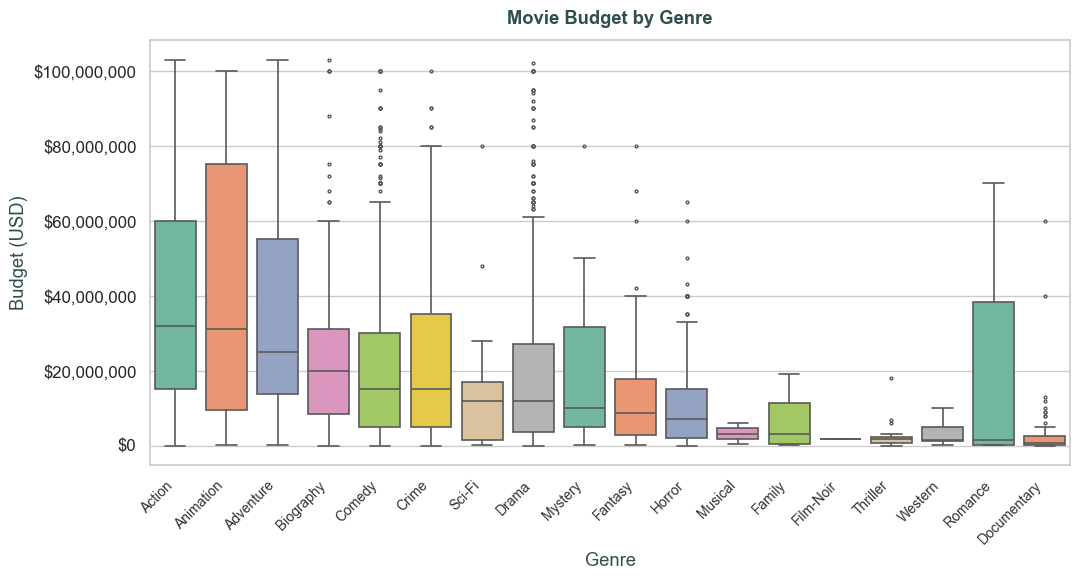

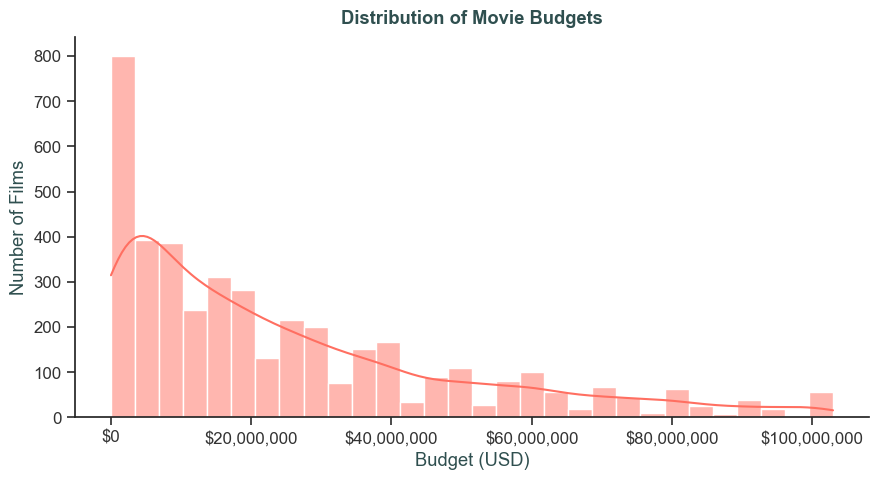

,count,mean,std,min,25%,50%,75%,max
main_genre,,,,,,,,
Action,892.000000,"$37,770,928",27331169.454197,"$7,000","$15,000,000","$32,000,000","$60,000,000","$103,000,000"
Adventure,348.000000,"$35,634,963",28625788.770769,"$150,000","$13,750,000","$25,000,000","$55,000,000","$103,000,000"
Animation,46.000000,"$41,280,000",33848983.900719,"$150,000","$9,525,000","$31,000,000","$75,000,000","$100,000,000"
Biography,230.000000,"$23,399,590",19650475.396624,$218,"$8,500,000","$20,000,000","$31,086,250","$103,000,000"
Comedy,1155.000000,"$20,518,247",20228489.202407,"$9,000","$5,000,000","$15,000,000","$30,000,000","$100,000,000"
Crime,294.000000,"$22,751,428",21528292.572981,"$3,250","$5,000,000","$15,000,000","$35,000,000","$100,000,000"
Documentary,65.000000,"$3,547,912",9051204.311617,"$1,100","$250,000","$750,000","$2,500,000","$60,000,000"
Drama,821.000000,"$19,253,102",21258027.701912,"$1,400","$3,500,000","$12,000,000","$27,000,000","$102,000,000"
Family,11.000000,"$6,010,909",6910094.723729,"$20,000","$425,000","$3,000,000","$11,250,000","$19,000,000"


/var/folders/0k/tz_kvvpj16ggzpq7nkbw635h0000gn/T/ipykernel_60377/1919110655.py:97: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


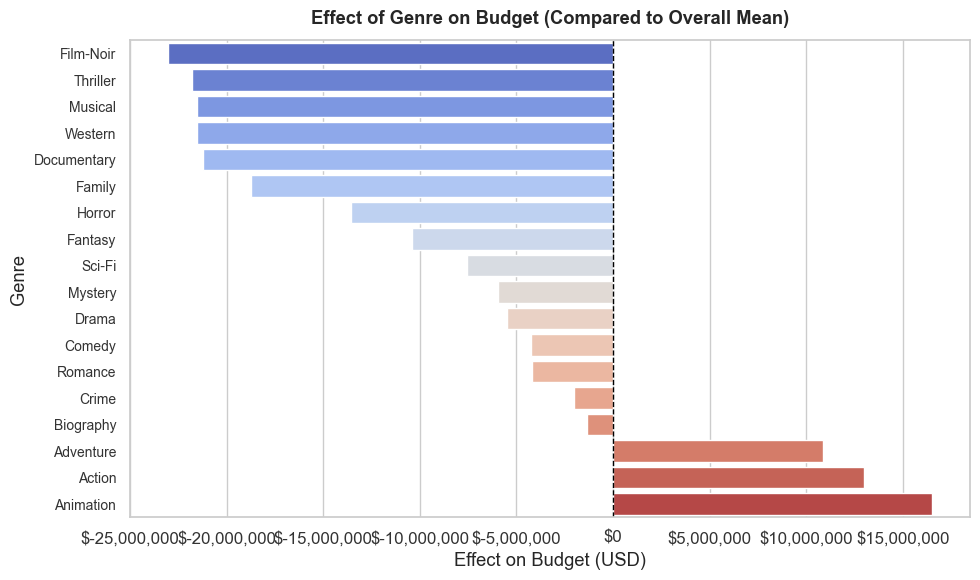

In [73]:
def q2_visualize(df):
    import matplotlib.pyplot as plt
    import matplotlib.ticker as mtick
    import seaborn as sns
    import pandas as pd

    # Clean
    if "main_genre" not in df.columns:
        df = df.copy()
        df['main_genre'] = df['genres'].str.split("|").str[0]

    df = df[['main_genre', 'budget']].dropna()

    # Boxplot
    with sns.axes_style("whitegrid"), sns.plotting_context("notebook", font_scale=1.1):
        fig, ax = plt.subplots(figsize=(11, 6))

        med_order = (
            df.groupby('main_genre')['budget']
              .median()
              .sort_values(ascending=False)
              .index
        )

        genre_colors = sns.color_palette("Set2", n_colors=len(med_order))

        sns.boxplot(
            data=df, x='main_genre', y='budget',
            order=med_order,
            palette=genre_colors,
            fliersize=2, linewidth=1.2, ax=ax
        )

        ax.set_title("Movie Budget by Genre", pad=12, weight='semibold', color='#2F4F4F')
        ax.set_xlabel("Genre", color='#2F4F4F')   
        ax.set_ylabel("Budget (USD)", color='#2F4F4F')
        ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))

        ax.set_xticklabels(
            ax.get_xticklabels(),
            rotation=45,
            ha='right',
            fontsize=10,
            color='#333333'
        )

        plt.tight_layout()
        plt.show()

    # Histogram
    with sns.axes_style("ticks"), sns.plotting_context("notebook", font_scale=1.1):
        fig, ax = plt.subplots(figsize=(9, 5))

        sns.histplot(
            df['budget'], bins=30, kde=True,
            color="#FF6F61", edgecolor="white", ax=ax
        )

        ax.set_title("Distribution of Movie Budgets", pad=10, weight='semibold', color='#2F4F4F')
        ax.set_xlabel("Budget (USD)", color='#2F4F4F')
        ax.set_ylabel("Number of Films", color='#2F4F4F')
        ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))

        ax.tick_params(axis='x', colors='#333333')
        ax.tick_params(axis='y', colors='#333333')

        sns.despine(ax=ax)
        plt.tight_layout()
        plt.show()

    # q2 data summary
    genre_summary = df.groupby('main_genre')['budget'].describe()

    display(
        genre_summary.style
            .format('${:,.0f}', subset=['mean', 'min', '25%', '50%', '75%', 'max'])
            .set_caption("Summary of Budget by Genre")
            .set_properties(**{'background-color': 'white', 'color': 'black'})
            .set_table_styles([
                {'selector': 'thead th', 'props': [('font-weight', 'bold')]},
                {'selector': 'th.row_heading', 'props': [('font-weight', 'bold')]},
                {'selector': 'caption', 'props': [('caption-side', 'top'), ('color', 'black'), ('font-size', '16px'), ('font-weight', 'bold')]}
            ])
    )

    # Genre effects calculation
    genre_means = df.groupby("main_genre")["budget"].mean()
    overall_mean = df["budget"].mean()
    genre_effects = genre_means - overall_mean
    genre_effects = pd.DataFrame(genre_effects).rename(columns={'budget': 'effect_on_budget'})
    genre_effects_sorted = genre_effects.sort_values('effect_on_budget')

    # Genre effects barplot
    with sns.axes_style("whitegrid"), sns.plotting_context("notebook", font_scale=1.1):
        fig, ax = plt.subplots(figsize=(10, 6))

        sns.barplot(
            x='effect_on_budget',
            y=genre_effects_sorted.index,
            data=genre_effects_sorted,
            palette="coolwarm",
            ax=ax
        )

        ax.axvline(0, color='black', linewidth=1, linestyle='--')  # zero reference line

        ax.set_title("Effect of Genre on Budget (Compared to Overall Mean)", pad=12, weight='semibold')
        ax.set_xlabel("Effect on Budget (USD)")
        ax.set_ylabel("Genre")
        ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))

        ax.tick_params(axis='y', labelsize=10, colors='#333333')
        ax.tick_params(axis='x', colors='#333333')

        plt.tight_layout()
        plt.show()

q2_visualize(q2_df)

Q2 Statistical Inference

In [74]:
def q2_inference():
    # ANOVA
    grouped_budgets = [group["budget"].values for _, group in q2_df.groupby("main_genre")]
    anova = st.f_oneway(*grouped_budgets)
    F = anova.statistic
    anova_pvalue = anova.pvalue
    anova_is_significant = anova_pvalue < alpha
    print(f"ANOVA: F={F}, p={anova_pvalue}, significant?: {anova_is_significant}")

q2_inference()

ANOVA: F=39.563500006321725, p=8.153185203104459e-122, significant?: True


**Q2 Formal Statistical Testing**

We will use the one-way *ANOVA* test.

Null Hypothesis ($H_0$): All the genres have the same mean budget.

Alternative Hypothesis ($H_1$): At least one genre has a different mean budget.

Significance Level: $\alpha = 0.05$. We will reject $H_0$ if the p-value $< 0.05$.

In [75]:
def q2_statistical_testing():
    alpha = 0.05

    grouped_budgets = [group["budget"].values for _, group in q2_df.groupby("main_genre")]
    anova = st.f_oneway(*grouped_budgets)
    F = anova.statistic
    p_value = anova.pvalue
    print(f"F = {F}, p-value = {p_value}")
    if p_value < alpha:
        print("We rejected H0 because the genres have different average budgets.")
    else:
        print("We failed to reject H0 because there is not enough evidence to claim that the genres have different average budgets.")
    
q2_statistical_testing()

F = 39.563500006321725, p-value = 8.153185203104459e-122
We rejected H0 because the genres have different average budgets.


**Conclusion:** The Boxplot visual showed the budget distribution for each genre in the IMDb data set and highlighted that some genres had visibly higher budgets than others. This allowed us to safely assume that genre does have an effect on the budget. This is further backed by our statistical testing using the ANOVA test which showed a large F value and a p-value less than 0.05. This indicates that at least one genre has a different average budget.  Which means that our null hypothesis, stating that all genres have the same average budget was rejected.  This result supports the conclusion that genre plays a meaningful role in budget allocation, and movie production should heavily consider a genre when approving the movie's budget. 

Research Question 3: Does the Director’s Name Influence the Number of Votes?

In [76]:
# Get director's name and number of votes DF
q3_df = df[['director_name', 'num_voted_users']].dropna()
q3_df = q3_df[q3_df['num_voted_users'] > 0]
q3_df = remove_outliers_iqr(q3_df, 'num_voted_users')

Q3 Exploratory Data Analysis (EDA)

/var/folders/0k/tz_kvvpj16ggzpq7nkbw635h0000gn/T/ipykernel_60377/4188969659.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


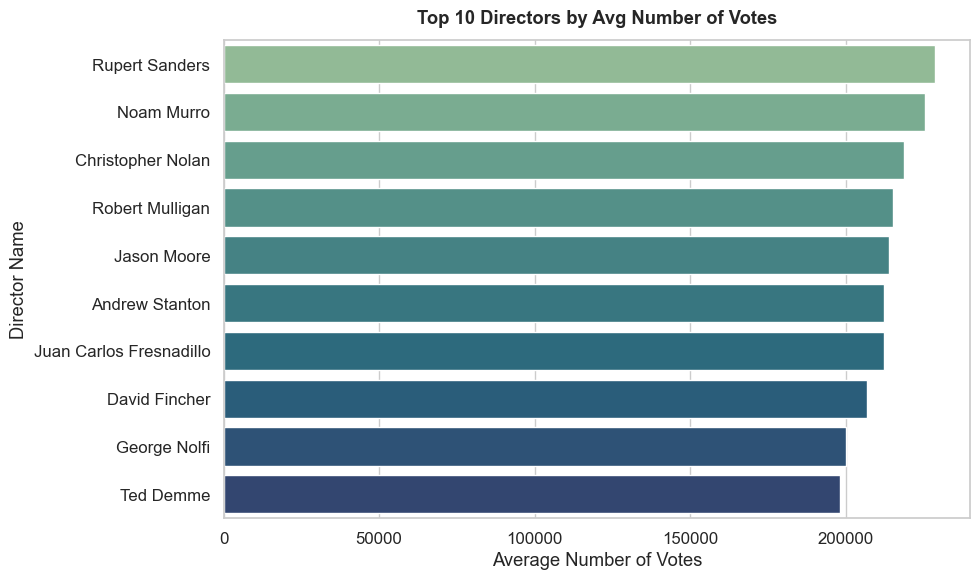

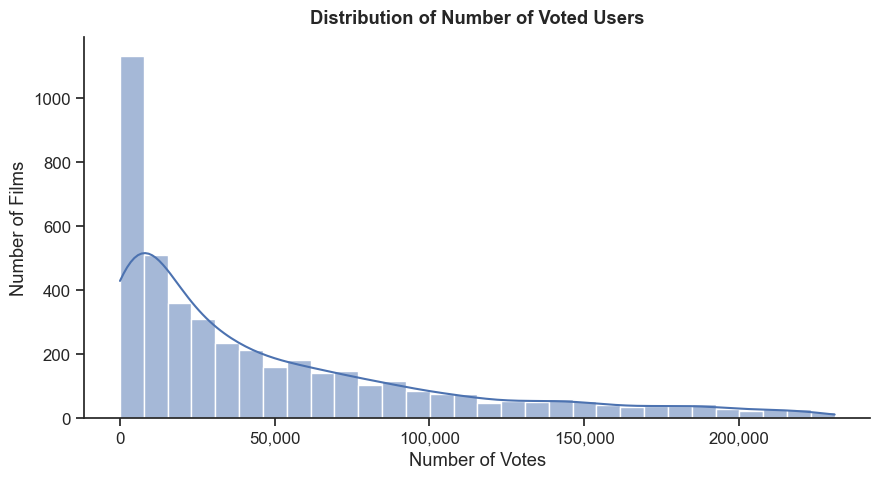

,count,mean,std,min,25%,50%,75%,max
director_name,,,,,,,,
Rupert Sanders,1.000000,"228,554",nan,"228,554","228,554","228,554","228,554","228,554"
Noam Murro,1.000000,"225,273",nan,"225,273","225,273","225,273","225,273","225,273"
Christopher Nolan,1.000000,"218,771",nan,"218,771","218,771","218,771","218,771","218,771"
Robert Mulligan,1.000000,"215,086",nan,"215,086","215,086","215,086","215,086","215,086"
Jason Moore,1.000000,"213,898",nan,"213,898","213,898","213,898","213,898","213,898"
Andrew Stanton,1.000000,"212,204",nan,"212,204","212,204","212,204","212,204","212,204"
Juan Carlos Fresnadillo,1.000000,"212,167",nan,"212,167","212,167","212,167","212,167","212,167"
David Fincher,2.000000,"206,895",1118.642928,"206,104","206,500","206,895","207,290","207,686"
George Nolfi,1.000000,"200,035",nan,"200,035","200,035","200,035","200,035","200,035"


In [77]:
def q3_visualize(df):
    import matplotlib.pyplot as plt
    import matplotlib.ticker as mtick
    import seaborn as sns
    import pandas as pd

    # Clean
    df = df[['director_name', 'num_voted_users']].dropna()

    # Barplot
    with sns.axes_style("whitegrid"), sns.plotting_context("notebook", font_scale=1.1):
        top_directors = (
            df.groupby('director_name')['num_voted_users']
              .mean()
              .sort_values(ascending=False)
              .head(10)
        )

        fig, ax = plt.subplots(figsize=(10, 6))

        sns.barplot(
            x=top_directors.values,
            y=top_directors.index,
            palette="crest",
            ax=ax
        )

        ax.set_title("Top 10 Directors by Avg Number of Votes", pad=12, weight='semibold')
        ax.set_xlabel("Average Number of Votes")
        ax.set_ylabel("Director Name")
        plt.tight_layout()
        plt.show()

    # Histogram
    with sns.axes_style("ticks"), sns.plotting_context("notebook", font_scale=1.1):
        fig, ax = plt.subplots(figsize=(9, 5))

        sns.histplot(
            df['num_voted_users'], bins=30, kde=True,
            color="#4C72B0", edgecolor="white", ax=ax
        )

        ax.set_title("Distribution of Number of Voted Users", pad=10, weight='semibold')
        ax.set_xlabel("Number of Votes")
        ax.set_ylabel("Number of Films")
        ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
        sns.despine(ax=ax)
        plt.tight_layout()
        plt.show()

    # q3 data summary
    director_summary = (
        df.groupby('director_name')['num_voted_users']
          .describe()
          .sort_values(by='mean', ascending=False)
          .head(10)
    )

    display(
        director_summary.style
            .format('{:,.0f}', subset=['mean', 'min', '25%', '50%', '75%', 'max'])
            .set_caption("Top 10 Directors by Average Number of Voted Users")
            .set_properties(**{'background-color': 'white', 'color': 'black'})
            .set_table_styles([
                {'selector': 'thead th', 'props': [('font-weight', 'bold')]},
                {'selector': 'th.row_heading', 'props': [('font-weight', 'bold')]},
                {'selector': 'caption', 'props': [('caption-side', 'top'), ('color', 'black'), ('font-size', '16px'), ('font-weight', 'bold')]}
            ])
    )

    
q3_visualize(q3_df)

Q3 Statistical Inference

In [78]:
def q3_inference():
    # ANOVA
    grouped_budgets = [group["num_voted_users"].values for _, group in q3_df.groupby("director_name")]
    anova = st.f_oneway(*grouped_budgets)
    F = anova.statistic
    anova_pvalue = anova.pvalue
    anova_is_significant = anova_pvalue < alpha
    print(f"ANOVA: F={F}, p={anova_pvalue}, significant?: {anova_is_significant}")

q3_inference()

ANOVA: F=1.5079854291798063, p=5.159543329481513e-22, significant?: True


**Q3 Formal Statistical Testing**

We will use the one-way *ANOVA* test.

Null Hypothesis ($H_0$): All the directors have the same mean number of votes.

Alternative Hypothesis ($H_1$): At least one director has a different mean number of votes.

Significance Level: $\alpha = 0.05$. We will reject $H_0$ if the p-value $< 0.05$.

In [79]:
def q3_statistical_testing():
    alpha = 0.05

    grouped_budgets = [group["num_voted_users"].values for _, group in q3_df.groupby("director_name")]
    F, p_value = st.f_oneway(*grouped_budgets)
    print(f"F = {F}, p-value = {p_value}")
    if p_value < alpha:
        print("We rejected H0 because the mean number of votes differs among the directors.")
    else:
        print("We failed to reject H0 because there is not enough evidence to claim that the directors have different mean number of votes.")
    
q3_statistical_testing()

F = 1.5079854291798063, p-value = 5.159543329481513e-22
We rejected H0 because the mean number of votes differs among the directors.


**Conclusion:** ANOVA test showed that there is a difference in the average number of votes across the movie directors meaning that a movie's director influences the number of votes the film will receive from the audience (p-value is very small). The possible implication of this finding: the movie productions should consider collaborating with the popular and highly-rated directors to boost the total number of votes.